In [1]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist
from sklearn.neighbors import NearestNeighbors, KDTree
from sklearn.metrics.pairwise import rbf_kernel

In [2]:
import scipy.io
mat = scipy.io.loadmat('Syndata.mat')
data = mat['data']
data.shape

(800, 2)

In [3]:
K = rbf_kernel(data, data, 0.5/1.8**2)
print(f"K: {K.shape}")
print(K[:10])

K: (800, 800)
[[1.         0.59074884 0.13457268 ... 0.57338521 0.45933699 0.55391671]
 [0.59074884 1.         0.44798158 ... 0.30198901 0.32430225 0.3045359 ]
 [0.13457268 0.44798158 1.         ... 0.0205365  0.02175677 0.02047644]
 ...
 [0.04446417 0.15316068 0.76746522 ... 0.00315454 0.0029463  0.00306847]
 [0.52420108 0.97270888 0.58496747 ... 0.21117854 0.22340615 0.21209356]
 [0.09093962 0.1754758  0.6411057  ... 0.0065074  0.00512237 0.0061704 ]]


In [4]:
def halving(K, m, candidate_index=None, lambda_=0.001):
    
    n = K.shape[0]
    # print(f'number of data: {n}')

    m = min(n, m)
    # print(f'number of samples: {m}')

    if candidate_index is None:
        candidate_index = np.array(range(n))
    
    # print(f'candidate_index: {candidate_index}')

    q = len(candidate_index)

    index = np.empty(m, dtype=int)
    # print(f'number of index: {index.shape}')

    print(f'Selecting {m} samples......')
    for i in range(m):
        score = np.zeros(q)
        for j in range(q):
            if candidate_index[j] == -1:
                continue
            else:
                k = candidate_index[j]
                # print(k)
                score[j] = np.dot(K[k, :], K[:, k]) / (K[k, k] + lambda_)
        
        I = score.argmax()
        # print(I)
        index[i] = candidate_index[I]

        candidate_index[I] = -1
        
        # update K
        # K = K - np.dot(K[:, index[i]], K[index[i], :]) / (K[index[i], index[i]] + lambda_)
        K = K - K[:, index[i]][:, np.newaxis] @ K[index[i], :][np.newaxis, :] / (K[index[i], index[i]] + lambda_)

    print('Done.\n')
    return index

In [5]:
indices = []
for i in range(1, 7):
    idx = halving(K, 100*i)
    indices.append(idx)

for i, sample in enumerate(indices, 1):
    print(f'Number of samples in iter_{i}: {len(set(sample))}')

Selecting 100 samples......
Done.

Selecting 200 samples......
Done.

Selecting 300 samples......
Done.

Selecting 400 samples......
Done.

Selecting 500 samples......
Done.

Selecting 600 samples......
Done.

Number of samples in iter_1: 100
Number of samples in iter_2: 200
Number of samples in iter_3: 300
Number of samples in iter_4: 400
Number of samples in iter_5: 500
Number of samples in iter_6: 600


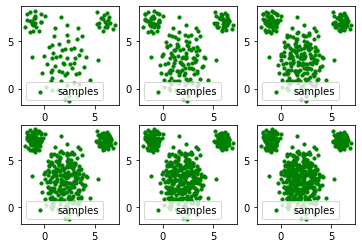

In [6]:
import matplotlib.pyplot as plt


fig = plt.figure()
# ax1 = plt.subplot(2,2,1)
# ax2 = plt.subplot(2,2,2)
# ax3 = plt.subplot(2,2,3)
# ax4 = plt.subplot(2,2,4)
for i, idx in enumerate(indices, 1):
    ax = fig.add_subplot(2,3,i)
    ax.scatter(data[idx, 0], data[idx, 1], color='g', s=10, label='samples')
    # ax.set(title='Iteration')
    ax.legend()

In [7]:
def number_density(data, center, radius):
    # print(f'length of data: {len(data)}\nlength of center: {len(center)}')
    f = 0
    for i in range(len(data)):
        ball_dist = []
        dist = np.zeros(len(center))
        for j in range(len(center)):
            dist[j] = np.linalg.norm(data[i, :] - center[j, :])
            if dist[j] < radius:
                ball_dist.append(dist[j])

        # print(np.exp(ball_dist/1.8))
        f += np.sum(np.exp(np.array(ball_dist)/1.8)**2) / (len(ball_dist) + 1)
    
    return f

In [8]:
def SDAL(data, k):

    kmeans = KMeans(n_clusters=k).fit(data)
    center = kmeans.cluster_centers_

    radius = 0.25
    num_data, _ = data.shape
    
    f = number_density(data, center, radius)

    for T in range(50):
        for j in range(k):
            ball = []
            dist = np.zeros(num_data)
            for i in range(num_data):
                dist[i] = np.linalg.norm(data[i, :] - center[j, :])
                if dist[i] < radius:
                    ball.append(data[i])
            # print(len(ball))
            if len(ball)==0:
                center[j] = center[j]
            else:
                center[j] = np.mean(np.array(ball), axis=0)
                # print(center[j])

        F = number_density(data, center, radius)

        if (F-f)==0 or len(np.argwhere(pdist(center)<2*radius))>0:
            break
        else:
            f = F
        radius*=1.1
    
    tree = KDTree(data)
    _, idx = tree.query(center, k=1)
    # print(idx)
    center = data[idx].squeeze()
            
    return center, radius

In [12]:
for i, idx in enumerate(indices, 1):
    center, radius = SDAL(data[idx], 5)
    print(f'Radius of iter_{i}: {radius}')

Radius of iter_1: 0.44289025000000026
Radius of iter_2: 0.4026275000000002
Radius of iter_3: 1.044312042353914
Radius of iter_4: 0.7132791765275007
Radius of iter_5: 0.6484356150250006
Radius of iter_6: 0.8630678035982761


Radius of iter_1: 0.275
Radius of iter_2: 0.4026275000000002
ipykernel_launcher:16: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
ipykernel_launcher:16: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
Radius of iter_3: 1.044312042353914
ipykernel_launcher:16: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
Radius of iter_4: 0.7132791765275007
ipykernel_launcher:16: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
Radius

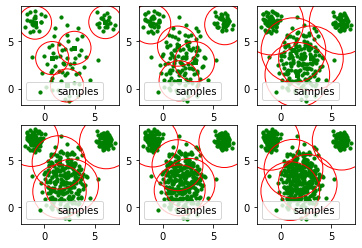

In [10]:
import matplotlib.pyplot as plt

# kmeans = KMeans(n_clusters=5).fit(data)
# center = kmeans.cluster_centers_
# radius = 0.25
# print(center)

fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)
for i, idx in enumerate(indices, 1):
    center, radius = SDAL(data[idx], 5)
    ax = fig.add_subplot(2,3,i)
    print(f'Radius of iter_{i}: {radius}')
    ax.scatter(data[idx, 0], data[idx, 1], color='g', s=10, label='samples')
    ax.scatter(center[:, 0], center[:, 1], c='g', marker='s', s=10)
    ax.scatter(center[:, 0], center[:, 1], c='', marker='o', edgecolors='r', s=4000*radius)
    # ax.set(title='Iteration')
    ax.legend()

ipykernel_launcher:12: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.


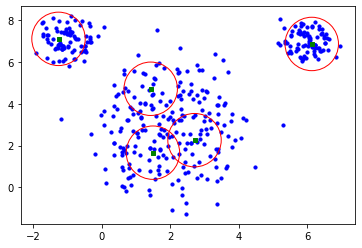

In [12]:
import matplotlib.pyplot as plt

# kmeans = KMeans(n_clusters=5).fit(data)
# center = kmeans.cluster_centers_
# radius = 0.25
# print(center)

fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)
plt.scatter(data[id, 0], data[id, 1], c='b', s=10)
plt.scatter(center[:, 0], center[:, 1], c='g', marker='s', s=10)
plt.scatter(center[:, 0], center[:, 1], c='', marker='o', edgecolors='r', s=4000*radius)
# circle = plt.Circle(center[:, 0], center[:, 1], radius)
# ax.add_patch(circle)